# Local Classifier Two-Sample Tests ($\ell$-C2ST)

After a density estimator has been trained with simulated data to obtain a posterior, the estimator should be made subject to several diagnostic tests, before being used for inference given the actual observed data. _Posterior Predictive Checks_ (see [previous tutorial](https://sbi-dev.github.io/sbi/tutorial/12_diagnostics_posterior_predictive_check/)) provide one way to "critique" a trained estimator via its predictive performance. Another approach is simulation-based calibration (see [previous tutorial](https://sbi-dev.github.io/sbi/tutorial/13_diagnostics_simulation_based_calibration/)), that evaluates whether the estimated posterior is balanced, i.e., neither over-confident nor under-confident. These checks are peformed ***in expectation (on average) over the observation space***. As such, SBC is a ***global*** validation method that can be viewed as a necessary condition (but not sufficient) for a valid inference algorithm: If SBC checks fail, this tells you that your inference is invalid. If SBC checks pass, *this is no guarantee that the posterior estimation is working*. Local Classifier Two-Sample Tests as developed by [Linhart et al, 2023](https://arxiv.org/abs/2306.03580) present a new ***local*** validation method that allow to evaluate the correctness of the posterior estimator ***at a fixed observation***. They provide necessary *and sufficient* conditions for the validity of the SBI-algorithm, as well as easy-to-interpret qualitative and quantiative diagnostics: If global checks (like SBC) fail, this enables to further investigate where (for which observation) and why (bias, overdispersion, etc.) the posterior estimator fails. If global validation checks pass, this allows to guarantee whether the inference is correct for a specific observation. 

**Local Classifier Two-Sample Tests** ($\ell$-C2ST) ...


## In a nutshell

Suppose your posterior estimator $q_\phi(\theta\mid x)$ was trained in an amortized way, meaning that we can quickly get samples for any new observation $x$.

To run $\ell$-C2ST, 

1. we sample **new** parameters from the prior of the problem at hand: $\Theta_i \sim p(\theta)$
2. we simulate corresponding "observations": $X_i = \mathrm{Simulator}(\Theta_i) \sim p(x\mid \Theta_i)$
3. we sample the estimated posterior at each observation: $Q_i \sim q_\phi(\theta \mid X_i)$

This creates a dataset of samples from the "estimated" and true joint distributions on which we train a binary classifier $d(\theta, x)$ to distinguish between:
- Class 0: the estimated joint $q(\theta \mid x)p(x)$
- Class 1: for the true joint distribution $p(\theta)p(x\mid\theta)$

Once the classifier is trained, we evaluate it for a given observation $x^\star$ and multiple samples $Q^\star_n \sim q_\phi(\theta \mid x^\star)$. This gives us a set of predicted probabilities $d(Q^\star_n, x^\star)$, that are then used to compute the different diagnostics:
- quantitative: test statistic, p-values 
- qualitative: heatmaps, PP-plots with confidence regions 
This proceedure can be repeated for several different observations, without having to retrain the classifiers, which allows to perform a thorough analysis of the failure modes of the posterior estimator.

**Quick reminder on hypothesis tests.** Additionaly to the observed test statistic $T^\star$, evaluating the test requires to
1. compute the "optimal" test statistics $T_h$ under the null hyposthesis (H0) of equal (true and estimated) distributions over multiple trials $h$ 
2. compute the p-value $p_v = \frac{1}{H}\sum_{h=1}^H \mathbb{I}(T_h > T^\star)$: *"How many times is the observed test statistic "better" (i.e. below) the optimal test statistic (under H0)?"*
3. choose a significance level $\alpha$ (typically $0.05$) that defines the rejection threshold and evaluate the test
- quantitatively: a p-value below this level indicates the rejection of the null hypothesis, meaning the detection of significant differences between the true and the estimated posterior. 
- qualitatively: visually check whether $T^\star$ falls into the $1-\alpha$ confidence region, computed by taking the corresponding quantiles of $(T_1,\dots, T_H)$.

### Key ideas behind $\ell$-C2ST

...

### What can $\ell$-C2ST diagnose?

...

To summarize $\ell$-C2ST can:

- ...
- ...

## Illustration on a benchmark example

We consider the Gaussian Mixture SBI task from [Lueckmann et al, 2021](https://arxiv.org/abs/2101.04653). It consists of inferring the common mean of a mixture of two two-dimensional Gaussian distributions, one with much broader covariance than the other:
- Prior: $p(\theta) = \mathcal{U}(-10,10)$
- Simulator: $p(x|\theta) = 0.5 \mathcal{N}(\theta, \mathbf{I}_2)+ 0.5 \mathcal{N}(\theta, 0.1 \times \mathbf{I}_2)$
- Dimensionality: $\theta \in \mathbb{R}^2$, $x \in \mathbb{R}^2$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

### SBI Task

In [3]:
from utils_17_diagnostics_lc2st import GaussianMixture

# SBI task: prior and simualtor
gmm = GaussianMixture()
prior = gmm.prior_dist
simulator = gmm.get_simulator()

# Number of samples for training, calibration and evaluation
N_TRAIN = 1000
N_CAL = 1000
N_EVAL = 10_000

### Posterior Inference

We use neural posterior estimation as our SBI-algorithm with a MAF as underlying density estimator. 

> Note: Here you could use any other SBI algorithm of your own choosing (e.g. NRE, NLE, etc.). IMPORTANT: make sure it is amortized (which corresponds to sequential methods with a signle round). 

We train the estimator on a small training set (`N_TRAIN=1000`) over a small number of epochs (`max_num_epochs=10`), which means that it doesn't converge. Therefore the diagnostics should detect major differences between the estimated and the true posterior (rejected null hypothesis).

> Note: You can play with the number of training samples or epochs to see whether this influences the quality of the posterior estimator and how it is reflected in the diagnostics.

In [11]:
from sbi.inference import SNPE, prepare_for_sbi

torch.manual_seed(42)

# Prepare the simulator and prior for inference
simulator, prior = prepare_for_sbi(simulator, prior)

# Sample training data for the density estimator
theta_train = prior.sample((N_TRAIN,))
x_train = simulator(theta_train)

# Train the neural posterior estimators
torch.manual_seed(42)
inference = SNPE(prior, density_estimator='maf', device='cpu')
inference = inference.append_simulations(theta=theta_train, x=x_train)
npe = inference.train(training_batch_size=256, max_num_epochs=10)

 Training neural network. Epochs trained: 11

### Evaluate the posterior estimator

In [12]:
# get reference observations
torch.manual_seed(0)
thetas_star = prior.sample((3,))
xs_star = simulator(thetas_star)

# Sample from the true and estimated posterior
post_samples_star = {}
ref_samples_star = {}
for i,x in enumerate(xs_star):
    post_samples_star[i] = npe.sample((N_EVAL,), condition=x).detach()
    ref_samples_star[i] = gmm._sample_reference_posterior(
        num_samples=1000,
        observation=x[None,:]
    )

#### Set-up $\ell$-C2ST

In [14]:
from sbi.diagnostics.lc2st import LC2ST

torch.manual_seed(42)

# sample calibration data
theta_cal = prior.sample((N_CAL,))
x_cal = simulator(theta_cal)
post_samples_cal = npe.sample((1,), x_cal)[:,0,:].detach()

# set up the LC2ST
lc2st = LC2ST(thetas=theta_cal, xs=x_cal, posterior_samples=post_samples_cal)
_ = lc2st.train_null()
_ = lc2st.train_data()

Training the classifiers under (H0) - permutation = True: 100%|██████████| 100/100 [00:24<00:00,  4.14it/s]


#### Quantitative diagnostics
Test statistics, confidence regions and p-values

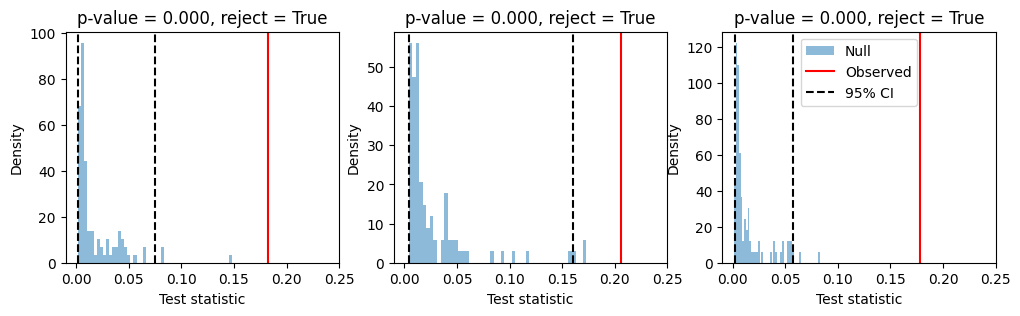

In [15]:
alpha = 0.05
fig, axes = plt.subplots(1,len(thetas_star), figsize=(12,3))
for i in range(len(thetas_star)):
    probas, scores = lc2st.scores_data(
        P_eval=post_samples_star[i],
        x_eval=xs_star[i],
        return_probas=True
    )
    T_data = lc2st.statistic_data(P_eval=post_samples_star[i], x_eval=xs_star[i])
    T_null = lc2st.statistics_null(P_eval=post_samples_star[i], x_eval=xs_star[i])
    p_value = lc2st.p_value(post_samples_star[i], xs_star[i])
    reject = lc2st.reject(post_samples_star[i], xs_star[i], alpha=alpha)

    # plot 95% confidence interval
    quantiles = np.quantile(T_null, [alpha/2, 1-alpha/2])
    axes[i].hist(T_null, bins=50, density=True, alpha=0.5, label="Null")
    axes[i].axvline(T_data, color="red", label="Observed")
    axes[i].axvline(quantiles[0], color="black", linestyle="--", label="95% CI")
    axes[i].axvline(quantiles[1], color="black", linestyle="--")
    axes[i].set_xlabel("Test statistic")
    axes[i].set_ylabel("Density")
    axes[i].set_xlim(-0.01,0.25)
    axes[i].set_title(f"p-value = {p_value:.3f}, reject = {reject}")
axes[i].legend()
plt.show()

#### Qualitative diagnostics

##### PP-Plots

> TODO: explain

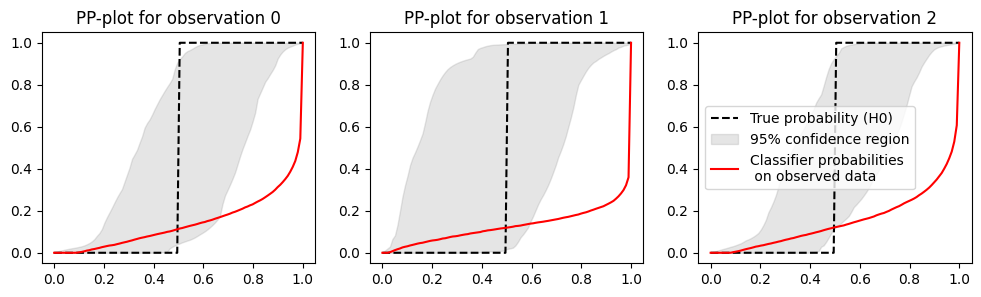

In [17]:
# PP-Plots
from sbi.analysis.plot import pp_plot_lc2st

fig, axes = plt.subplots(1,len(thetas_star), figsize=(12,3))
for i in range(len(thetas_star)):
    probas_data, _ = lc2st.scores_data(
        P_eval=post_samples_star[i],
        x_eval=xs_star[i],
        return_probas=True
    )
    probas_null, _ = lc2st.statistics_null(
        P_eval=post_samples_star[i],
        x_eval=xs_star[i],
        return_probas=True
    )

    pp_plot_lc2st(
        probas=[probas_data],
        probas_null=probas_null,
        labels=["Classifier probabilities \n on observed data"],
        colors=["red"], ax=axes[i]
    )
    axes[i].set_title(f"PP-plot for observation {i}")
axes[i].legend()
plt.show()

##### Heatmap of classifier probabilities

> TODO: explain

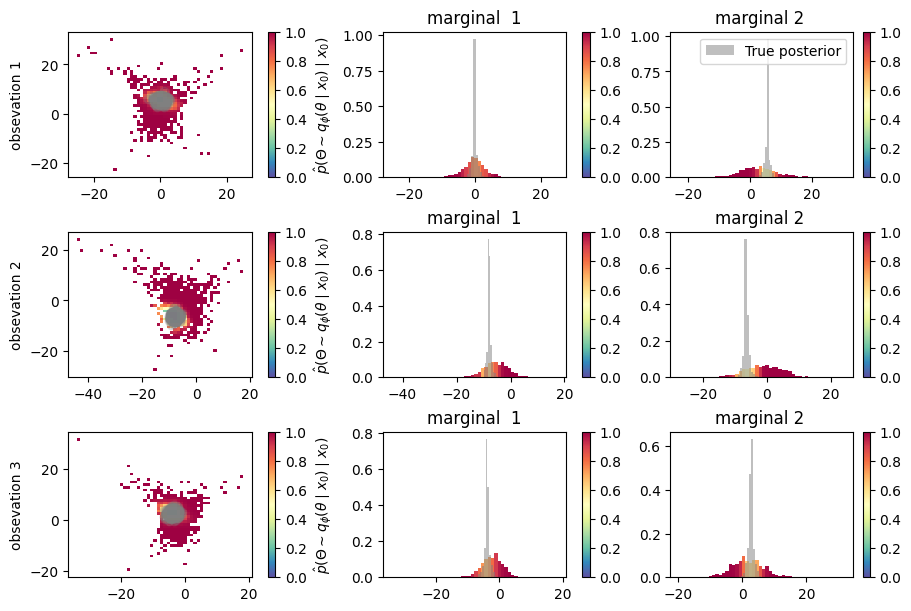

In [20]:
from sbi.analysis.plot import pairplot_with_proba_intensity
from sbi.analysis.test_utils import compute_dfs_with_probas_marginals

fig, axes = plt.subplots(3,len(thetas_star), figsize=(9,6), constrained_layout=True)
for i in range(len(thetas_star)):
    probas_data, _ = lc2st.scores_data(
        P_eval=post_samples_star[i][:1000],
        x_eval=xs_star[i],
        return_probas=True
    )
    dfs = compute_dfs_with_probas_marginals(probas_data[0], post_samples_star[i][:1000])
    # 2d histogram
    pairplot_with_proba_intensity(
        dfs['0_1'],
        dim=2,
        ax=axes[i][0],
        z_space=False,
        n_bins=50
    )
    axes[i][0].scatter(
        ref_samples_star[i][:,0],
        ref_samples_star[i][:,1],
        alpha=0.2, color="gray",
        label="True posterior"
    )

    # marginal 1
    pairplot_with_proba_intensity(
        dfs['0'],
        dim=1,
        ax=axes[i][1],
        z_space=False,
        n_bins=50
    )
    axes[i][1].hist(
        ref_samples_star[i][:,0],
        density=True,
        bins=10,
        alpha=0.5,
        label="True Posterior",
        color="gray"
    )

    # marginal 2
    pairplot_with_proba_intensity(
        dfs['1'],
        dim=1,
        ax=axes[i][2],
        z_space=False,
        n_bins=50
    )
    axes[i][2].hist(
        ref_samples_star[i][:,1],
        density=True,
        bins=10,
        alpha=0.5,
        label="True posterior",
        color="gray"
    )

    axes[i][1].set_title("marginal  1")
    axes[i][2].set_title("marginal 2 ")

    for j in range(3):
        axes[j][0].set_ylabel(f"obsevation {j + 1}")
    axes[0][2].legend()
plt.show()